Simulating 2D single molecule switching (SMS) data -- also known as PALM or STORM. Basically, these are widefield fluorescence microscopy images that contain diffraciton-limited spots.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
from fijitools.helpers.coordinate import Coordinate

In [2]:
from endocytosis.simulation.image_components import FieldOfView, Spot
from endocytosis.simulation.psfmodel import SimpleGaussian2D
from endocytosis.simulation.noise import NoiseModel
%matplotlib inline

We can use the Coordinate class to set a global pixelsize. A Coordinate is a dict subclass whose keys are unit names, e.g. 'px' for pixels and 'nm' for nanometers, and the values are the values in that unit of measure.

In [3]:
PIXELSIZE = Coordinate(px=(1., 1.), nm=(80., 80.))

When we instantiate a Coordinate, if we input a value for one of 'nm', 'um' or 'm' it automatically generates the corresponding values for the other two. Note that if we create a Coordinate whose, for example, 'nm' value is in conflict with the 'um' value, it uses data for 'nm'.

In [4]:
PIXELSIZE

{'px': array([1., 1.]),
 'nm': array([80., 80.]),
 'um': array([0.08, 0.08]),
 'm': array([8.e-05, 8.e-05])}

To generate the diffraction-limited spots, we need a PSF model. Let's keep things simple by using...the SimpleGaussian2D class. For this we'll need values for sigma, x, and y, which are the standard deviation, and xy coordinates relative to the center. Sigma is a 2D Coordinate, whose dimensions represent the standard deviation along the x and y axes.

In [5]:
sigma = Coordinate(nm=(100., 100.))

In [6]:
sigma

{'nm': array([100., 100.]),
 'um': array([0.1, 0.1]),
 'm': array([1.e-04, 1.e-04])}

In [7]:
sigma.pixelsize = PIXELSIZE
psf = SimpleGaussian2D(sigma)

To generate an image of just the PSF, we call its 'render' method. This requires arguemnts for A (amplitude, i.e. signal intensity) and shape (i.e. shape of the output image, in pixels).

In [8]:
psf_im = psf.render(10., 0, 0, (32, 32))

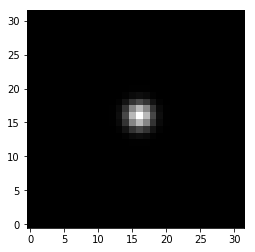

In [9]:
plt.imshow(psf_im, cmap=plt.cm.gray, origin='lower')

We also need a camera noise model. We derive this from camera metadata stored in a YAML file.

In [10]:
path = os.path.abspath(os.path.join(os.pardir, 'endocytosis', 'test', 'simulation', 'data', 'camera.yaml'))
nm = NoiseModel()
nm.load_camera_metadata(path, 'X-9309')
nm.use_camera(True, 30, 2)

Finally, we create the FieldOfView object, which can render our simulated image. It will also contain our diffraction-limited spots.

In [11]:
# pixelsize can only be set if psfmodel's pixelsize hasn't been set
del psf.sigma['px']
fov = FieldOfView((128, 128), PIXELSIZE, psfmodel=psf, noise_model=nm)

To generate an image, we call the 'render' method. Since we haven't added any spots yet, all we see is camera noise.

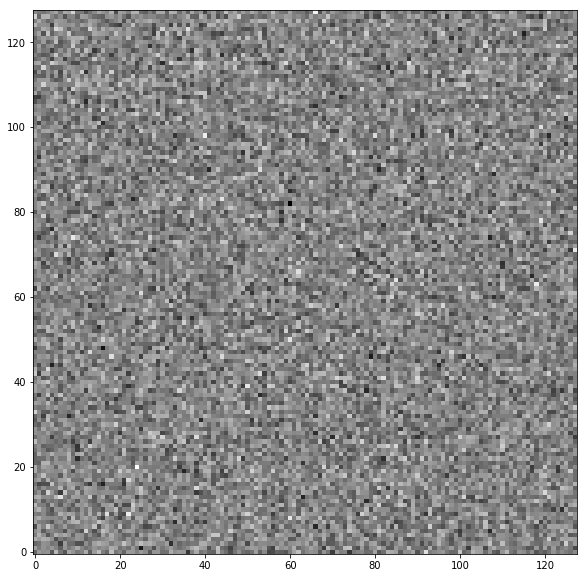

In [12]:
fov_im = fov.render()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(fov.render(), cmap=plt.cm.gray, origin='lower')

Let's add a few spots. To do this, we need their location, expressed as a Coordinate, and their amplitudes.

In [13]:
n = 30 # number of spots
shape = np.array(fov.shape)
coords = [Coordinate(px=c) for c in np.random.rand(n, 2) * shape]
A = np.random.rand(n) * 200

for c, a in zip(coords, A):
    _ = fov.add_spot(c, a)

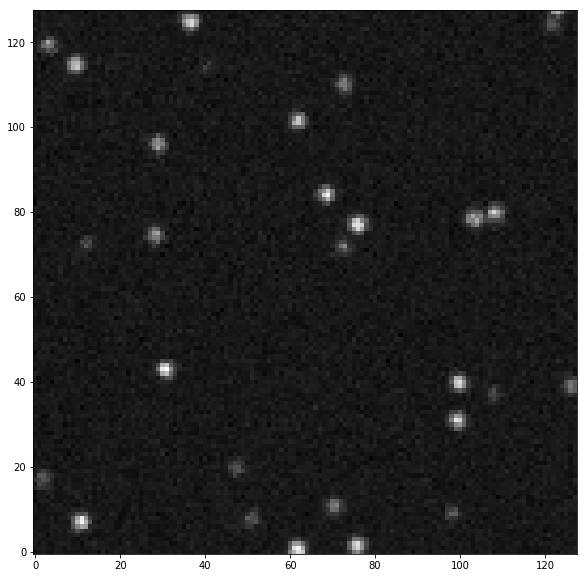

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(fov.render(), cmap=plt.cm.gray, origin='lower')

Data is saved as as an HDF5 file.
Structure is: 

                ['image']                             (original image data)
                    attrs: 'pixelsize' 'pixelunits'
                ['spots']['image']                    (cropped spots)
                    attrs: 'pixelsize' 'pixelunits'
                ['spots']['topleft']                  (pixel coordinates of top left corner of each cropped spot)
                ['ground_truth']['centroid']          (pixel coordinates of each spot center, shape (n, 2))
                                ['A']                 (amplitude of each spot)
                                ['sigma']             (standard deviation of each gaussian spot)                

In [15]:
if os.path.isfile('image_simulation.h5'):
    os.remove('image_simulation.h5')
fov.save('image_simulation.h5')

A sample of the cropped spots:

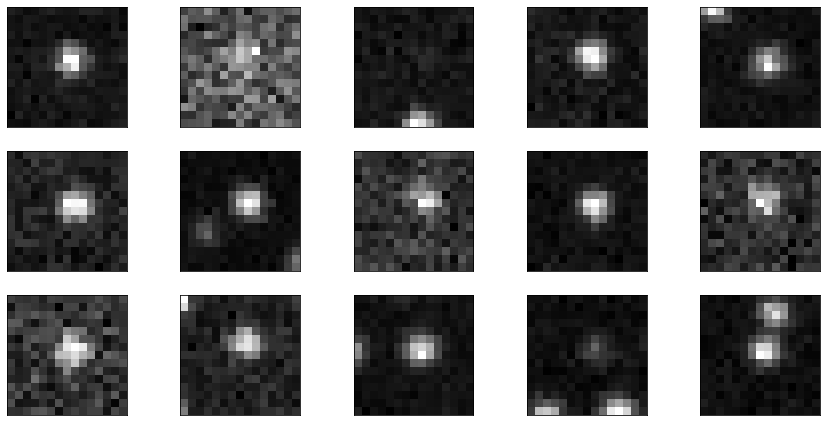

In [16]:
fig, ax = plt.subplots(3, 5, figsize=(15, 7.5))

with h5py.File('image_simulation.h5') as f:
    for i, _ax in enumerate(ax.ravel()):
        _ax.xaxis.set_visible(False)
        _ax.yaxis.set_visible(False)
        _ax.imshow(f['spots/image'].value[i], cmap=plt.cm.gray, origin='lower')

Sample of the coordinate data.

In [17]:
with h5py.File('image_simulation.h5') as f:
    for v in f['ground_truth'].values():
        print('{}: {}'.format(v.name, [str(_v) for _v in v.value[:2]]))

/ground_truth/A: ['120.53939', '18.521648']
/ground_truth/centroid: ['[101.009415  61.231052]', '[114.03536   39.816742]']
/ground_truth/sigma: ['1.25', '1.25']
